In [1]:
#Importing libraries

import json
import os
import re

import pandas as pd

import matplotlib.pyplot as plt

# We bring the json back here from the data base and show what we want

In [2]:
# Function to find all the branches of the json
def find_branches(dictionary, depth, max_depth, parent_key=None):
    branches = []
    for key, value in dictionary.items():
        current_key = key if parent_key is None else f"{parent_key}\\{key}"  # Change '.' to '\\'
        if isinstance(value, dict) and depth < max_depth:
            branches.extend(find_branches(value, depth + 1, max_depth, current_key))
        else:
            branches.append(current_key)
    return branches


# Function to find the deepness of a dictionnary
def find_nested_depth(dictionary, current_depth=0):
    max_depth = current_depth
    for value in dictionary.values():
        if isinstance(value, dict):
            depth = find_nested_depth(value, current_depth + 1)
            max_depth = max(max_depth, depth)
    return max_depth

# json to table

In [29]:
#In this part we are extracting all the dataset from all the extractions we have done. These datasets are saved with there file names and request in order to combine them later
path_to_json = "scrapings/"
files_name = os.listdir(path_to_json)

dataframes = {}
requests_saved = []

for file in files_name:
    full_path = os.path.join(path_to_json, file)
    if os.path.isfile(full_path):
        with open(full_path, 'r') as myfile:
            datas = json.load(myfile)

            for data in datas:

                max_depth = find_nested_depth(data)
                all_branches = find_branches(data, 1, max_depth)
                for branches in all_branches:
                    req = "data"
                    title = str()
                    requests = str()
                    for branch in branches.split('\\'):
                        req += f"['{branch}']"
                        title += branch + ' '
                        requests += f"['{branch}']"
                    result = eval(req)
                    requests_saved.append(requests)
                    variable_name = f"df_{file}_{req}"
                    
                    dataframes[variable_name] = pd.DataFrame(result)
                    
requests_saved_cleaned = list(set(requests_saved))

In [30]:
def chain_to_list(chaine):
    return re.findall(r"\['(.*?)'\]", chaine)
requests_saved_cleaned_list = [chain_to_list(request) for request in requests_saved_cleaned]

In [31]:
a = requests_saved_cleaned_list[0][0]
b = requests_saved_cleaned_list[0][1]
c = requests_saved_cleaned_list[0][2]
my_final_request = []
my_final_request.append(a)
my_final_request.append(b)
my_final_request.append(c)
my_final_request

['U-Bend Light Bulbs & Lamps',
 'LED Ballast-Bypass (UL Type B) U-Bend Lamps',
 'T8 1-5/8 in U-Bend Leg Spacing']

In [35]:
def list_to_chain(liste):
    elements = [f"['{element}']" for element in liste]
    chain = ''.join(elements)
    return chain

my_final_request_chain = list_to_chain(my_final_request)

print(my_final_request_chain)


['U-Bend Light Bulbs & Lamps']['LED Ballast-Bypass (UL Type B) U-Bend Lamps']['T8 1-5/8 in U-Bend Leg Spacing']


ma note : je lis tous les fichiers pour en sortir toute les requete. Premier dropdown is requests_saved_cleaned[i][0]. Je filtre ensuite avec ce premier categorie qui me donne la suite et ainsi de suite. Ceci va permettre de construire la requette pour la suite. On cherchera dans chaque json cette requette, extraction puis concat puis graphique

Clés correspondantes au modèle regex :
df_2024-04-26_mon_fichier.json_data['U-Bend Light Bulbs & Lamps']['LED Ballast-Bypass (UL Type B) U-Bend Lamps']['T8 1-5/8 in U-Bend Leg Spacing']
df_2024-04-27_mon_fichier.json_data['U-Bend Light Bulbs & Lamps']['LED Ballast-Bypass (UL Type B) U-Bend Lamps']['T8 1-5/8 in U-Bend Leg Spacing']


,Wattage,Date,Incandescent Wattage Equivalency,Color Temperature,Light Output,Shatter-Resistant,Bulb Designation,Brand,Price,Ref
0,13 W,2024-04-26,28 W; 32 W,3500K,"1,800 lm",No,LED13BDT8/U/835,CURRENT,$31.54,0
3,13 W,2024-04-27,28 W; 32 W,3500K,"1,800 lm",No,LED13BDT8/U/835,CURRENT,$31.54,0
1,13 W,2024-04-26,28 W; 32 W,4000K,"1,850 lm",No,LED13BDT8/U/840,CURRENT,$31.54,1
4,13 W,2024-04-27,28 W; 32 W,4000K,"1,850 lm",No,LED13BDT8/U/840,CURRENT,$31.54,1
2,13 W,2024-04-26,28 W; 32 W,5000K,"1,850 lm",No,LED13BDT8/U/850,CURRENT,$32.90,2
5,13 W,2024-04-27,28 W; 32 W,5000K,"1,850 lm",No,LED13BDT8/U/850,CURRENT,$32.90,2


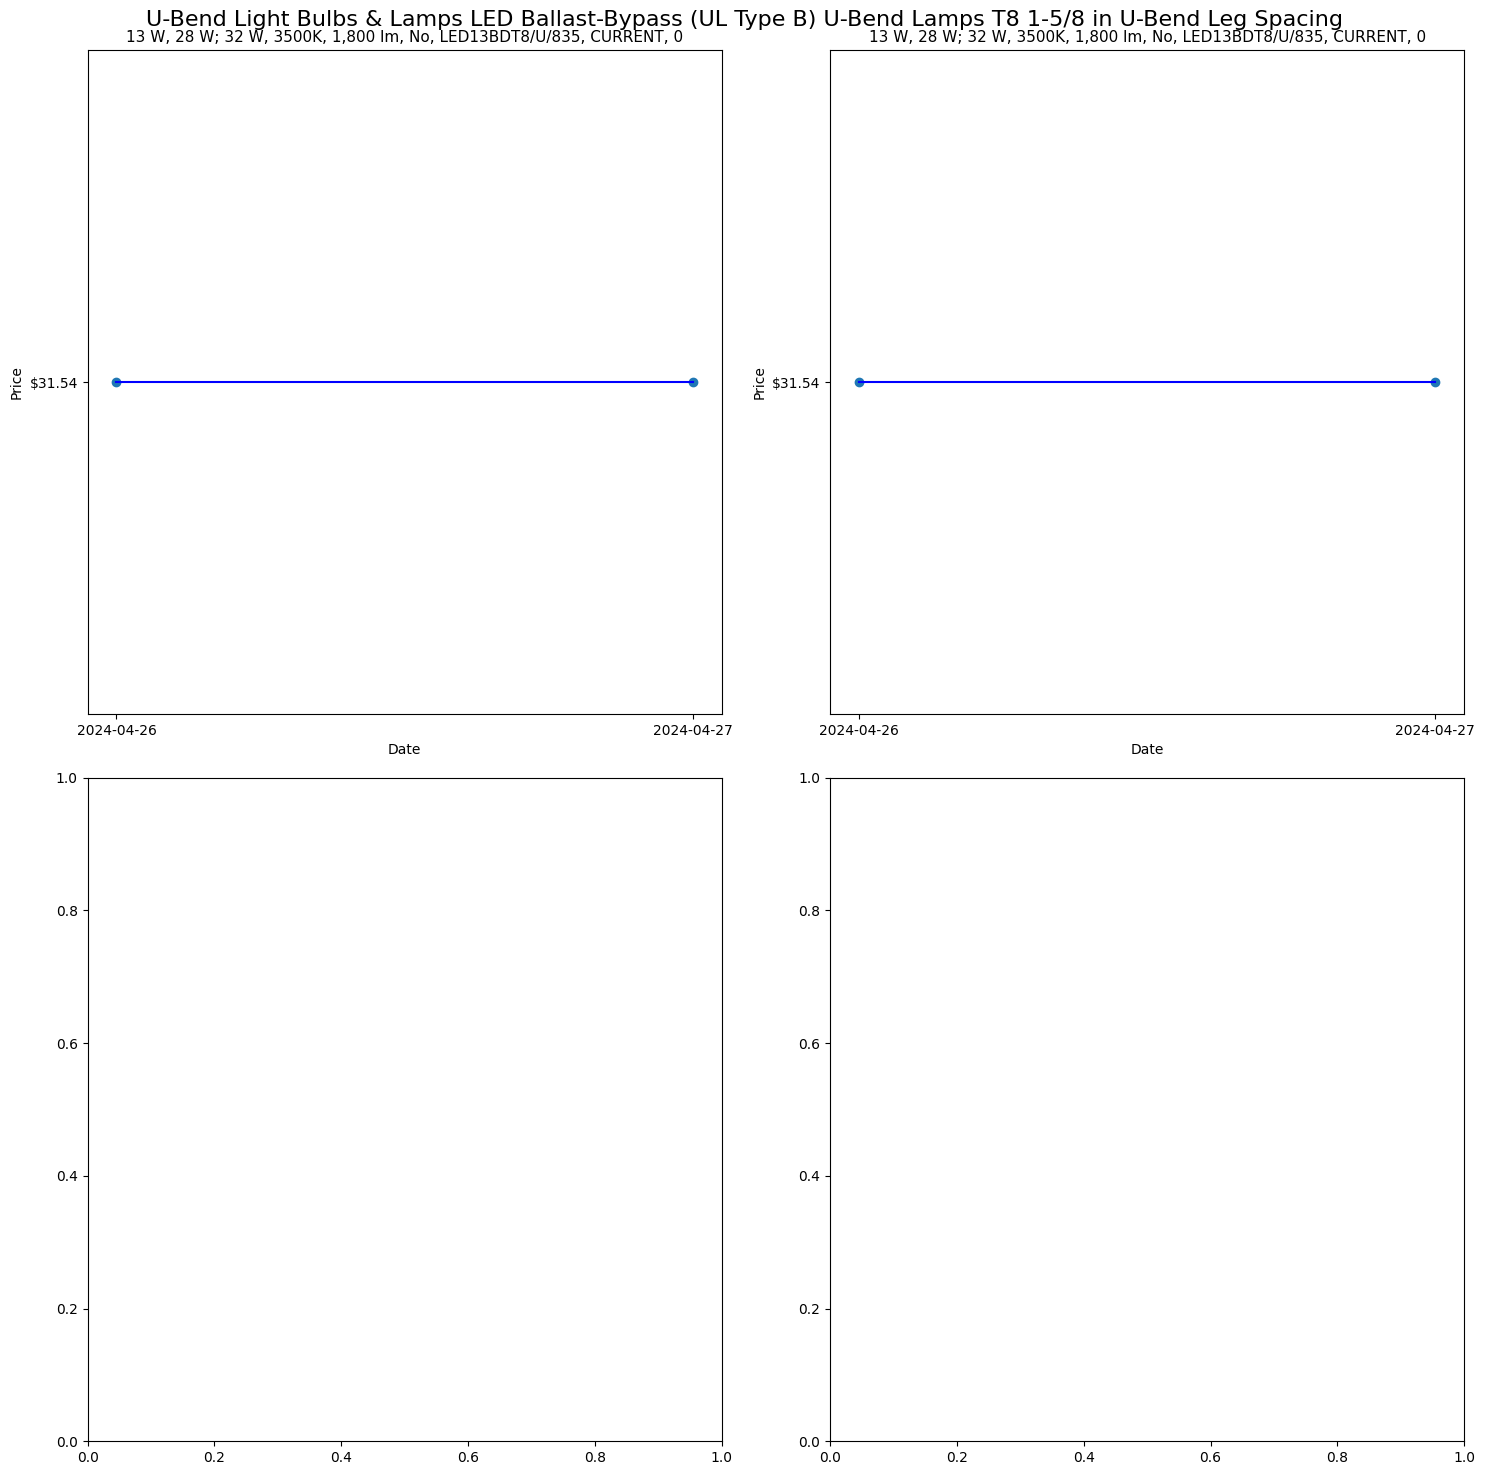

In [37]:
modele_regex = r"df_\d{4}-\d{2}-\d{2}_mon_fichier\.json_data" + re.escape(my_final_request_chain)

cles_trouvees = []

for cle in dataframes.keys():
    
    if re.match(modele_regex, cle):
        cles_trouvees.append(cle)

print("Clés correspondantes au modèle regex :")
dataframes_to_concat = []
for cle_trouvee in cles_trouvees:
    print(cle_trouvee)
    dataframes_to_concat.append(dataframes[cle_trouvee])

df_concatene = pd.concat(dataframes_to_concat, ignore_index=True)

#In order to thing the same items, I attribute them a Ref number. If the items is the same, everything but price and date has to be the same
colonnes_a_exclure = ['Date', 'Price']

df_concatene['Ref'] = df_concatene.groupby([colonne for colonne in df_concatene.columns if colonne not in colonnes_a_exclure]).ngroup()
df_concatene.sort_values(by=['Ref'], inplace=True)

display(df_concatene)

fig, axes = plt.subplots(nrows=(max(df_concatene['Ref']) // 2) + 1, ncols=2, figsize=(15, 15))
fig.suptitle(my_final_request_chain.replace("[", "").replace("]", "").replace("''", " ").replace("'", ""), fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < max(df_concatene['Ref']):
        df = df_concatene[df_concatene['Ref'] == i]
        ax.plot(df['Date'], df['Price'], color='blue', linestyle='-')  
        ax.scatter(x=df['Date'], y=df['Price'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        
        first_row_values = df_concatene.drop(columns=['Date', 'Price']).iloc[0].values
        string_first_row = ', '.join(map(str, first_row_values))
        ax.set_title(string_first_row, fontsize = 11)

plt.tight_layout()

plt.show()

In [ ]:
#Here, we want to concate the dataset of everydate : If I scrapped some lightings yesterday and today, I want to concat both (or more) datasets using the names given before and regex
for request in requests_saved_cleaned: 
    modele_regex = r"df_\d{4}-\d{2}-\d{2}_mon_fichier\.json_data" + re.escape(request)

    cles_trouvees = []

    for cle in dataframes.keys():
        
        if re.match(modele_regex, cle):
            cles_trouvees.append(cle)

    print("Clés correspondantes au modèle regex :")
    dataframes_to_concat = []
    for cle_trouvee in cles_trouvees:
        print(cle_trouvee)
        dataframes_to_concat.append(dataframes[cle_trouvee])

    df_concatene = pd.concat(dataframes_to_concat, ignore_index=True)
    
    #In order to thing the same items, I attribute them a Ref number. If the items is the same, everything but price and date has to be the same
    colonnes_a_exclure = ['Date', 'Price']

    df_concatene['Ref'] = df_concatene.groupby([colonne for colonne in df_concatene.columns if colonne not in colonnes_a_exclure]).ngroup()
    df_concatene.sort_values(by=['Ref'], inplace=True)
    
    display(df_concatene)

    fig, axes = plt.subplots(nrows=(max(df_concatene['Ref']) // 2) + 1, ncols=2, figsize=(15, 15))
    fig.suptitle(request.replace("[", "").replace("]", "").replace("''", " ").replace("'", ""), fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < max(df_concatene['Ref']):
            df = df_concatene[df_concatene['Ref'] == i]
            ax.plot(df['Date'], df['Price'], color='blue', linestyle='-')  
            ax.scatter(x=df['Date'], y=df['Price'])
            ax.set_xlabel('Date')
            ax.set_ylabel('Price')
            
            first_row_values = df_concatene.drop(columns=['Date', 'Price']).iloc[0].values
            string_first_row = ', '.join(map(str, first_row_values))
            ax.set_title(string_first_row, fontsize = 11)

    plt.tight_layout()

    plt.show()